<a href="https://colab.research.google.com/github/literalEval/GraphINVENT/blob/master/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing the environment

We first need to install all the libraries and modules we will be using for generating molecules using GraphINVENT

In [ ]:
################## Installing Conda #####################

%env PYTHONPATH=
! rm -rf Miniconda3-py38_23.1.0-1-Linux-x86_64.sh.* # In case this is run multiple times
! wget https://repo.anaconda.com/miniconda/Miniconda3-py38_23.1.0-1-Linux-x86_64.sh
# ! wget https://repo.anaconda.com/archive/Anaconda3-2022.10-Linux-x86_64.sh
! chmod +x Miniconda3-py38_23.1.0-1-Linux-x86_64.sh 
! bash ./Miniconda3-py38_23.1.0-1-Linux-x86_64.sh -b -f -p /usr/local

! conda install --channel defaults conda python=3.8 --yes
! conda update --channel defaults --all --yes

import sys
sys.path.append('/usr/local/lib/python3.8/site-packages/')

! conda init bash

################ Cloning GraphINVENT ####################

! rm -rf ./GraphINVENT # In case this is run multiple times
! git clone https://github.com/literalEval/GraphINVENT.git
%cd GraphINVENT
! ls

################ Activating our environment #############

! conda env create -f environments/graphinvent.yml
! source ~/.bashrc
! source activate graphinvent
! eval "$(conda shell.bash hook)"
! source ~/.bashrc

In [ ]:
%%bash
pwd
source activate graphinvent
conda install ipykernel -y

# Preparing a new dataset
Once we have selected a dataset to study, we must prepare it so that it agrees with the format expected by the program. GraphINVENT expects, for each dataset, three splits in SMILES format. Each split should be named as follows:

- train.smi
- test.smi
- valid.smi

These should contain the training set, test set, and validation set, respectively. It is not important for the SMILES to be canonical, and it also does not matter if the file has a header or not. How many structures you put in each split is also up to you (generally the training set is larger than the testing and validation set).

In [ ]:
%%bash
pwd
source activate graphinvent

python3.8
"""
Example submission script for a GraphINVENT training job (distribution-
based training, not fine-tuning/optimization job). This can be used to
pre-train a model before a fine-tuning (via reinforcement learning) job.

To run, type:
(graphinvent) ~/GraphINVENT$ python submit-pre-training.py
"""
# load general packages and functions
import csv
import sys
import os
from pathlib import Path
import subprocess
import time
import torch
import matplotlib.pyplot as plt


# define what you want to do for the specified job(s)
DATASET          = "gdb13_1K-debug"    # dataset name in "./data/pre-training/"
JOB_TYPE         = "train"             # "preprocess", "train", "generate", or "test"
JOBDIR_START_IDX = 0                   # where to start indexing job dirs
N_JOBS           = 1                   # number of jobs to run per model
RESTART          = False               # whether or not this is a restart job
FORCE_OVERWRITE  = True                # overwrite job directories which already exist
JOBNAME          = "example-job-name"  # used to create a sub directory

# if running using SLURM sbatch, specify params below
USE_SLURM = False                        # use SLURM or not
RUN_TIME  = "1-00:00:00"                 # hh:mm:ss
MEM_GB    = 20                           # required RAM in GB

# for SLURM jobs, set partition to run job on (preprocessing jobs run entirely on
# CPU, so no need to request GPU partition; all other job types benefit from running
# on a GPU)
if JOB_TYPE == "preprocess":
    PARTITION     = "core"
    CPUS_PER_TASK = 1
else:
    PARTITION     = "gpu"
    CPUS_PER_TASK = 4

# set paths here
HOME             = str(Path.home())
PYTHON_PATH      = "/usr/local/envs/graphinvent/bin/python3.8"
GRAPHINVENT_PATH = "./graphinvent/"
DATA_PATH        = "./data/pre-training/"

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

# define dataset-specific parameters
params = {
    "atom_types"   : ["C", "N", "O", "S", "Cl"],
    "formal_charge": [-1, 0, +1],
    "max_n_nodes"  : 13,
    "job_type"     : JOB_TYPE,
    "dataset_dir"  : f"{DATA_PATH}{DATASET}/",
    "restart"      : RESTART,
    "model"        : "GGNN",
    "sample_every" : 2,
    "init_lr"      : 1e-4,
    "epochs"       : 100,
    "batch_size"   : 50,
    "block_size"   : 1000,
    "device"       : DEVICE,
    "n_samples"    : 100,
    # additional paramaters can be defined here, if different from the "defaults"
    # for instance, for "generate" jobs, don't forget to specify "generation_epoch"
    # and "n_samples"
}


def submit() -> None:
    """
    Creates and submits submission script. Uses global variables defined at top
    of this file.
    """
    check_paths()

    # create an output directory
    dataset_output_path = f"{HOME}/GraphINVENT/output_{DATASET}"
    tensorboard_path    = os.path.join(dataset_output_path, "tensorboard")
    if JOBNAME != "":
        dataset_output_path = os.path.join(dataset_output_path, JOBNAME)
        tensorboard_path    = os.path.join(tensorboard_path, JOBNAME)

    os.makedirs(dataset_output_path, exist_ok=True)
    os.makedirs(tensorboard_path, exist_ok=True)
    print(f"* Creating dataset directory {dataset_output_path}/", flush=True)

    # submit `N_JOBS` separate jobs
    jobdir_end_idx = JOBDIR_START_IDX + N_JOBS
    for job_idx in range(JOBDIR_START_IDX, jobdir_end_idx):

        # specify and create the job subdirectory if it does not exist
        params["job_dir"]         = f"{dataset_output_path}/job_{job_idx}/"
        params["tensorboard_dir"] = f"{tensorboard_path}/job_{job_idx}/"

        # create the directory if it does not exist already, otherwise raises an
        # error, which is good because *might* not want to override data our
        # existing directories!
        os.makedirs(params["tensorboard_dir"], exist_ok=True)
        try:
            job_dir_exists_already = bool(
                JOB_TYPE in ["generate", "test"] or FORCE_OVERWRITE
            )
            os.makedirs(params["job_dir"], exist_ok=job_dir_exists_already)
            print(
                f"* Creating model subdirectory {dataset_output_path}/job_{job_idx}/",
                flush=True,
            )
        except FileExistsError:
            print(
                f"-- Model subdirectory {dataset_output_path}/job_{job_idx}/ already exists.",
                flush=True,
            )
            if not RESTART:
                continue

        # write the `input.csv` file
        write_input_csv(params_dict=params, filename="input.csv")

        # write `submit.sh` and submit
        if USE_SLURM:
            print("* Writing submission script.", flush=True)
            write_submission_script(job_dir=params["job_dir"],
                                    job_idx=job_idx,
                                    job_type=params["job_type"],
                                    max_n_nodes=params["max_n_nodes"],
                                    runtime=RUN_TIME,
                                    mem=MEM_GB,
                                    ptn=PARTITION,
                                    cpu_per_task=CPUS_PER_TASK,
                                    python_bin_path=PYTHON_PATH)

            print("* Submitting job to SLURM.", flush=True)
            subprocess.run(["sbatch", params["job_dir"] + "submit.sh"],
                           check=True)
        else:
            print("* Running job as a normal process.", flush=True)
            subprocess.run(["ls", f"{PYTHON_PATH}"], check=True)
            subprocess.run([f"{PYTHON_PATH}",
                            f"{GRAPHINVENT_PATH}main.py",
                            "--job-dir",
                            params["job_dir"]],
                           check=True)

        # sleep a few secs before submitting next job
        print("-- Sleeping 2 seconds.")
        time.sleep(2)


def write_input_csv(params_dict : dict, filename : str="params.csv") -> None:
    """
    Writes job parameters/hyperparameters in `params_dict` to CSV using the specified 
    `filename`.
    """
    dict_path = params_dict["job_dir"] + filename

    with open(dict_path, "w") as csv_file:

        writer = csv.writer(csv_file, delimiter=";")
        for key, value in params_dict.items():
            writer.writerow([key, value])


def write_submission_script(job_dir : str, job_idx : int, job_type : str, max_n_nodes : int,
                            runtime : str, mem : int, ptn : str, cpu_per_task : int,
                            python_bin_path : str) -> None:
    """
    Writes a submission script (`submit.sh`).

    Args:
    ----
        job_dir (str)         : Job running directory.
        job_idx (int)         : Job idx.
        job_type (str)        : Type of job to run.
        max_n_nodes (int)     : Maximum number of nodes in dataset.
        runtime (str)         : Job run-time limit in hh:mm:ss format.
        mem (int)             : Gigabytes to reserve.
        ptn (str)             : Partition to use, either "core" (CPU) or "gpu" (GPU).
        cpu_per_task (int)    : How many CPUs to use per task.
        python_bin_path (str) : Path to Python binary to use.
    """
    submit_filename = job_dir + "submit.sh"
    with open(submit_filename, "w") as submit_file:
        submit_file.write("#!/bin/bash\n")
        submit_file.write(f"#SBATCH --job-name={job_type}{max_n_nodes}_{job_idx}\n")
        submit_file.write(f"#SBATCH --output={job_type}{max_n_nodes}_{job_idx}o\n")
        submit_file.write(f"#SBATCH --time={runtime}\n")
        submit_file.write(f"#SBATCH --mem={mem}g\n")
        submit_file.write(f"#SBATCH --partition={ptn}\n")
        submit_file.write("#SBATCH --nodes=1\n")
        submit_file.write(f"#SBATCH --cpus-per-task={cpu_per_task}\n")
        if ptn == "gpu":
            submit_file.write("#SBATCH --gres=gpu:1\n")
        submit_file.write("hostname\n")
        submit_file.write("export QT_QPA_PLATFORM='offscreen'\n")
        submit_file.write(f"{python_bin_path} {GRAPHINVENT_PATH}main.py --job-dir {job_dir}")
        submit_file.write(f" > {job_dir}output.o${{SLURM_JOB_ID}}\n")


def check_paths() -> None:
    """
    Checks that paths to Python binary, data, and GraphINVENT are properly
    defined before running a job, and tells the user to define them if not.
    """
    for path in [PYTHON_PATH, GRAPHINVENT_PATH, DATA_PATH]:
        if "path/to/" in path:
            print("!!!")
            print("* Update the following paths in `submit.py` before running:")
            print("-- `PYTHON_PATH`\n-- `GRAPHINVENT_PATH`\n-- `DATA_PATH`")
            sys.exit(0)

submit()

# Generating New Molecules from the Trained Model

Now that we have trained our model by the dataset, it is time to generate new molecules from it. We simply need to change `JOB_TYPE` to `generate` and the same script will now generate new molecules from repsective trained model.

In [ ]:
%%bash
pwd
source activate graphinvent

python3.8
# load general packages and functions
import csv
import sys
import os
from pathlib import Path
import subprocess
import time
import torch
import matplotlib.pyplot as plt


# define what you want to do for the specified job(s)
DATASET          = "gdb13_1K-debug"    # dataset name in "./data/pre-training/"
JOB_TYPE         = "generate"          # "preprocess", "train", "generate", or "test"
JOBDIR_START_IDX = 0                   # where to start indexing job dirs
N_JOBS           = 1                   # number of jobs to run per model
RESTART          = False               # whether or not this is a restart job
FORCE_OVERWRITE  = True                # overwrite job directories which already exist
JOBNAME          = "example-job-name"  # used to create a sub directory

# if running using SLURM sbatch, specify params below
USE_SLURM = False                        # use SLURM or not
RUN_TIME  = "1-00:00:00"                 # hh:mm:ss
MEM_GB    = 20                           # required RAM in GB

# for SLURM jobs, set partition to run job on (preprocessing jobs run entirely on
# CPU, so no need to request GPU partition; all other job types benefit from running
# on a GPU)
if JOB_TYPE == "preprocess":
    PARTITION     = "core"
    CPUS_PER_TASK = 1
else:
    PARTITION     = "gpu"
    CPUS_PER_TASK = 4

# set paths here
HOME             = str(Path.home())
PYTHON_PATH      = "/usr/local/envs/graphinvent/bin/python3.8"
GRAPHINVENT_PATH = "./graphinvent/"
DATA_PATH        = "./data/pre-training/"

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

# define dataset-specific parameters
params = {
    "atom_types"   : ["C", "N", "O", "S", "Cl"],
    "formal_charge": [-1, 0, +1],
    "max_n_nodes"  : 13,
    "job_type"     : JOB_TYPE,
    "dataset_dir"  : f"{DATA_PATH}{DATASET}/",
    "restart"      : RESTART,
    "model"        : "GGNN",
    "sample_every" : 2,
    "init_lr"      : 1e-4,
    "epochs"       : 100,
    "batch_size"   : 50,
    "block_size"   : 1000,
    "device"       : DEVICE,
    "n_samples"    : 100,
    # additional paramaters can be defined here, if different from the "defaults"
    # for instance, for "generate" jobs, don't forget to specify "generation_epoch"
    # and "n_samples"
}


def submit() -> None:
    """
    Creates and submits submission script. Uses global variables defined at top
    of this file.
    """
    check_paths()

    # create an output directory
    dataset_output_path = f"{HOME}/GraphINVENT/output_{DATASET}"
    tensorboard_path    = os.path.join(dataset_output_path, "tensorboard")
    if JOBNAME != "":
        dataset_output_path = os.path.join(dataset_output_path, JOBNAME)
        tensorboard_path    = os.path.join(tensorboard_path, JOBNAME)

    os.makedirs(dataset_output_path, exist_ok=True)
    os.makedirs(tensorboard_path, exist_ok=True)
    print(f"* Creating dataset directory {dataset_output_path}/", flush=True)

    # submit `N_JOBS` separate jobs
    jobdir_end_idx = JOBDIR_START_IDX + N_JOBS
    for job_idx in range(JOBDIR_START_IDX, jobdir_end_idx):

        # specify and create the job subdirectory if it does not exist
        params["job_dir"]         = f"{dataset_output_path}/job_{job_idx}/"
        params["tensorboard_dir"] = f"{tensorboard_path}/job_{job_idx}/"

        # create the directory if it does not exist already, otherwise raises an
        # error, which is good because *might* not want to override data our
        # existing directories!
        os.makedirs(params["tensorboard_dir"], exist_ok=True)
        try:
            job_dir_exists_already = bool(
                JOB_TYPE in ["generate", "test"] or FORCE_OVERWRITE
            )
            os.makedirs(params["job_dir"], exist_ok=job_dir_exists_already)
            print(
                f"* Creating model subdirectory {dataset_output_path}/job_{job_idx}/",
                flush=True,
            )
        except FileExistsError:
            print(
                f"-- Model subdirectory {dataset_output_path}/job_{job_idx}/ already exists.",
                flush=True,
            )
            if not RESTART:
                continue

        # write the `input.csv` file
        write_input_csv(params_dict=params, filename="input.csv")

        # write `submit.sh` and submit
        if USE_SLURM:
            print("* Writing submission script.", flush=True)
            write_submission_script(job_dir=params["job_dir"],
                                    job_idx=job_idx,
                                    job_type=params["job_type"],
                                    max_n_nodes=params["max_n_nodes"],
                                    runtime=RUN_TIME,
                                    mem=MEM_GB,
                                    ptn=PARTITION,
                                    cpu_per_task=CPUS_PER_TASK,
                                    python_bin_path=PYTHON_PATH)

            print("* Submitting job to SLURM.", flush=True)
            subprocess.run(["sbatch", params["job_dir"] + "submit.sh"],
                           check=True)
        else:
            print("* Running job as a normal process.", flush=True)
            subprocess.run(["ls", f"{PYTHON_PATH}"], check=True)
            subprocess.run([f"{PYTHON_PATH}",
                            f"{GRAPHINVENT_PATH}main.py",
                            "--job-dir",
                            params["job_dir"]],
                           check=True)

        # sleep a few secs before submitting next job
        print("-- Sleeping 2 seconds.")
        time.sleep(2)


def write_input_csv(params_dict : dict, filename : str="params.csv") -> None:
    """
    Writes job parameters/hyperparameters in `params_dict` to CSV using the specified 
    `filename`.
    """
    dict_path = params_dict["job_dir"] + filename

    with open(dict_path, "w") as csv_file:

        writer = csv.writer(csv_file, delimiter=";")
        for key, value in params_dict.items():
            writer.writerow([key, value])


def write_submission_script(job_dir : str, job_idx : int, job_type : str, max_n_nodes : int,
                            runtime : str, mem : int, ptn : str, cpu_per_task : int,
                            python_bin_path : str) -> None:
    """
    Writes a submission script (`submit.sh`).

    Args:
    ----
        job_dir (str)         : Job running directory.
        job_idx (int)         : Job idx.
        job_type (str)        : Type of job to run.
        max_n_nodes (int)     : Maximum number of nodes in dataset.
        runtime (str)         : Job run-time limit in hh:mm:ss format.
        mem (int)             : Gigabytes to reserve.
        ptn (str)             : Partition to use, either "core" (CPU) or "gpu" (GPU).
        cpu_per_task (int)    : How many CPUs to use per task.
        python_bin_path (str) : Path to Python binary to use.
    """
    submit_filename = job_dir + "submit.sh"
    with open(submit_filename, "w") as submit_file:
        submit_file.write("#!/bin/bash\n")
        submit_file.write(f"#SBATCH --job-name={job_type}{max_n_nodes}_{job_idx}\n")
        submit_file.write(f"#SBATCH --output={job_type}{max_n_nodes}_{job_idx}o\n")
        submit_file.write(f"#SBATCH --time={runtime}\n")
        submit_file.write(f"#SBATCH --mem={mem}g\n")
        submit_file.write(f"#SBATCH --partition={ptn}\n")
        submit_file.write("#SBATCH --nodes=1\n")
        submit_file.write(f"#SBATCH --cpus-per-task={cpu_per_task}\n")
        if ptn == "gpu":
            submit_file.write("#SBATCH --gres=gpu:1\n")
        submit_file.write("hostname\n")
        submit_file.write("export QT_QPA_PLATFORM='offscreen'\n")
        submit_file.write(f"{python_bin_path} {GRAPHINVENT_PATH}main.py --job-dir {job_dir}")
        submit_file.write(f" > {job_dir}output.o${{SLURM_JOB_ID}}\n")


def check_paths() -> None:
    """
    Checks that paths to Python binary, data, and GraphINVENT are properly
    defined before running a job, and tells the user to define them if not.
    """
    for path in [PYTHON_PATH, GRAPHINVENT_PATH, DATA_PATH]:
        if "path/to/" in path:
            print("!!!")
            print("* Update the following paths in `submit.py` before running:")
            print("-- `PYTHON_PATH`\n-- `GRAPHINVENT_PATH`\n-- `DATA_PATH`")
            sys.exit(0)

submit()

# Post Processing

The generated moleules' SMILES are not always in the format we would like, and we need to process the generated data before it becomes usable for further analysis.

## Filtering out invalid entries
By default, GraphINVENT writes a "Xe" placeholder when an invalid molecular graph is generated, as an invalid molecular graph cannot be converted to a SMILES string for saving. The placeholder is used because the NLL is written for all generated graphs in a separate file, where the same line number in the *.nll file corresponds to the same line number in the *.smi file. Similarly, if an empty graph samples an invalid action as the first action, then no SMILES can be generated for an empty graph, so the corresponding line for an empty graph in a SMILES file contains only the "ID" of the molecule.

For visualization, you might be interested in viewing only the valid molecular graphs. The SMILES for the generated molecules can thus be post-processed as follows to remove empty and invalid entries from a file before visualization:

In [ ]:
! sed -i "/Xe/d" /root/GraphINVENT/output_gdb13_1K-debug/example-job-name/job_0/generation/epoch_2.smi          # remove "Xe" placeholders from file
! sed -i "/^ [0-9]\+$/d" /root/GraphINVENT/output_gdb13_1K-debug/example-job-name/job_0/generation/epoch_2.smi  # remove empty graphs from file

# Visualizing Molecules

So we generated some molecules using GraphINVENT, and will certainly want to explore them visually. Below we provide some examples using RDKit for visualizing the molecules in simple but elegant grids.

## Drawing a grid of molecules



### What if thousands of molecules are generated ?

Assuming we use the trained models to generate thousands (if not more) molecules, we probably don't want to visualize all of them in one massive grid. A more reasonable thing to do is to randomly sample a small subset for visualization.

An example script for drawing 100 randomly selected molecules is shown below:

In [ ]:
! python3.8 -m pip install rdkit

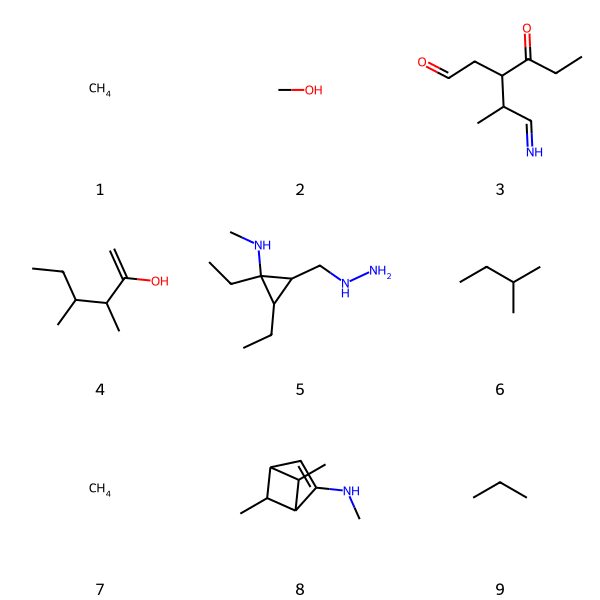

In [ ]:
import math
import random
import rdkit
from PIL import Image
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.rdmolfiles import SmilesMolSupplier

smi_file = "/root/GraphINVENT/output_gdb13_1K-debug/example-job-name/job_0/generation/epoch_2.smi"

# load molecules from file
mols = SmilesMolSupplier(smi_file, sanitize=True, nameColumn=-1)

n_samples = 9
mols_list = [mol for mol in mols]
mols_sampled = random.sample(mols_list, n_samples)  # sample 9 random molecules to visualize

mols_per_row = int(math.sqrt(n_samples))            # make a square grid

png_filename=smi_file[:-3] + "png"  # name of PNG file to create
labels=list(range(1, n_samples + 1))       # label structures with a number

# draw the molecules (creates a PIL image)
img = MolsToGridImage(mols=mols_sampled,
                      molsPerRow=mols_per_row,
                      legends=[str(i) for i in labels])

with open(png_filename,'wb+') as outf:
    outf.write(img.data)

Image.open(png_filename)

Alternatively, you could first randomly sample 9 molecules from your source file, save them in a new file, and draw everything in the new file:

In [ ]:
! shuffle -n 9 /root/GraphINVENT/output_gdb13_1K-debug/example-job-name/job_0/generation/epoch_2.smi \
> /root/GraphINVENT/output_gdb13_1K-debug/example-job-name/job_0/generation/shuffled.smi

In [ ]:
import rdkit
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.rdmolfiles import SmilesMolSupplier

smi_file = "/root/GraphINVENT/output_gdb13_1K-debug/example-job-name/job_0/generation/shuffled.smi"

# load molecules from file
mols = SmilesMolSupplier(smi_file, sanitize=True, nameColumn=-1)

png_filename=smi_file[:-3] + ".shuffled.png"  # name of PNG file to create
labels=list(range(n_samples))       # label structures with a number

# draw the molecules (creates a PIL image)
img = MolsToGridImage(mols=mols,
                      molsPerRow=10,
                      legends=[str(i) for i in labels])

with open(png_filename,'wb+') as outf:
    outf.write(img.data)

Image.open(png_filename)